
# Muturretik muturrerako solasaldi sistema

## Proposatzailea: Jon Ander Campos

## Egileak: Julen Etxaniz eta Aitor Zubillaga

## Deskribapena

Proiektu honetan ikasketa sakonean oinarritutako muturretik muturrerako solasaldi sistema bat garatuko duzu Bahdanau et al. (2014) [1] lanean oinarritua eta filmetako azpitituluak erabiliz (Lison et al. (2016)) [2]. Honetarako, dialogoa itzulpen ataza bat bezala proposatuko dugu, ikusi hurrengo adibidea:

* Itzulpen automatikoa :
    * Sistemaren sarrera -> esaldia jatorri hizkuntza batean: "Egun on guztioi."
    * Sistemaren irteera -> esaldia helburu hizkuntzan: "Buenos días a todos."
* Dialogoa:
    * Sistemaren sarrera ->dialogoko partaide baten esaldia: "Egun on guztioi."
    * Sistemaren irteera -> sarrerako esaldiari erantzuna: "Baita zuri ere."

## Helburuak

Helburuak zailtasun mailaren araberakoak izango dira:

* Z1: Deskargatu ingeleserako entrenatua izan den muturretik muturrerako
solasaldi sistema eta probatu ezazu (inferentzia garaian CPUan exekutatzeko gai izan beharko zinateke). Aztertu itzazu ere sistemaren arkitektura eta
entrenamendurako erabili diren datuak.

* Z2: Orain duzun sistemak ingelesez bakarrik ulertzen du, zergatik ez hau
euskarara moldatu? Deskargatu itzazu euskarazko filmetako azpitituluak eta
entrenatu ezazu sistema berri bat. Sistemaren entrenamendua Google
Colaboratory erabiliz egin behar baduzu sarearen tamaina txikitu beharko duzu. Kodean bertan topatuko dituzu parametro gomendagarrienak.

* Z3 (1. aukera): Esku artean dituzun sistemekin solasteko modu oso interesgarria eskaintzen du Telegramek. Aukeratu ezazu bi sistemetako bat eta moldatu Telegrameko bot bezala funtziona dezan. Kasu honetan sistema inferentziarako erabili behar denez, CPUan exekutatzeko gai izan beharko zinateke.

* Z3 (2.aukera): Orain arte erabili dituzun sistema guztiak testuingurua kontutan hartu gabe funtzionatzen dute eta hau oso hurbilpen kaxkarra da dialogorako. Hortaz, saiatu zaitez dialogoaren testuingurua kontuan hartzen duen sistema berri bat garatzen. Nahi bezain besteko konplexutasuna gehitu daiteke atal honetan baina aurreko txandako galdera kontutan hartzea nahikoa izango litzateke testuinguruaren ezagutza minimo bat sistemari emateko.

## Materialak

Proiektu honetarako materialak hurrengoak dira:

* Z1: [Bertan](https://drive.google.com/drive/folders/1a6JIZ96fupi8gHxYf5ytgkBc9zenJtQU) topatuko dituzu sistema eta hau exekutatzeko kodea. Ezertan hasi aurretik irakurri ezazu "IRAKURRI.txt" fitxategia.

* Z2: Hurrengo helbidean hizkuntza askotako azpititulu fitxategiak dituzu:
[http://opus.nlpl.eu/OpenSubtitles-v2018.php​](http://opus.nlpl.eu/OpenSubtitles-v2018.php​). Euskarakoak [​bertan​](http://opus.nlpl.eu/download.php?f=OpenSubtitles/v2018/mono/OpenSubtitles.raw.eu.gz) daude.

* Z3 (1.aukera): Hurrengo helbidean topatuko duzu Telegrameko APIa Pythonerako: https://github.com/python-telegram-bot/python-telegram-bot​. Lehen bota sortzeko jarrabideak [​bertan​](https://github.com/python-telegram-bot/python-telegram-bot/wiki/Extensions-%E2%80%93-Your-first-Bot) topa ditzakezu.

## Erreferentziak

Notebook hau hurrengo artikulu eta kodeetan oinarritzen da. Alde batetik, Pytorch-eko tutorialak erabili dira. Bestetik, [Ben Trevett](https://github.com/bentrevett)-en tutorialak ere erabilgarriak izan dira.

### Papers

[1] Bahdanau, D., Cho, K., & Bengio, Y. (2014). [Neural machine translation by jointly learning to align and translate](https://arxiv.org/abs/1409.0473). _arXiv preprint arXiv: 1409. 0473_

[2] Lison, P., & Tiedemann, J. (2016). [Opensubtitles2016: Extracting large parallel corpora from movie and tv subtitles](https://www.aclweb.org/anthology/L16-1147/).

### PyTorch

[Language Translation with TorchText](https://pytorch.org/tutorials/beginner/torchtext_translation_tutorial.html)

[NLP From Scratch: Translation with a Sequence to Sequence Network and Attention](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

### GitHub

[1 - Sequence to Sequence Learning with Neural Networks.ipynb](https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb)

[3 - Neural Machine Translation by Jointly Learning to Align and Translate.ipynb](https://github.com/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb)

[4 - Packed Padded Sequences, Masking, Inference and BLEU.ipynb](https://github.com/bentrevett/pytorch-seq2seq/blob/master/4%20-%20Packed%20Padded%20Sequences%2C%20Masking%2C%20Inference%20and%20BLEU.ipynb)

### Colab

[1 - Sequence to Sequence Learning with Neural Networks.ipynb](https://colab.research.google.com/github/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb)

[3 - Neural Machine Translation by Jointly Learning to Align and Translate.ipynb](https://colab.research.google.com/github/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb#scrollTo=YzSfu75AtQ97)

[4 - Packed Padded Sequences, Masking, Inference and BLEU.ipynb](https://colab.research.google.com/github/bentrevett/pytorch-seq2seq/blob/master/4%20-%20Packed%20Padded%20Sequences%2C%20Masking%2C%20Inference%20and%20BLEU.ipynb)


## Get Data

Esan bezala, filmetako azpitituluak erabiliko ditugu gure ereduak entrenatzeko. Hurrengo helbidean hizkuntza askotako azpititulu fitxategiak dituzu:
[http://opus.nlpl.eu/OpenSubtitles-v2018.php​](http://opus.nlpl.eu/OpenSubtitles-v2018.php​). Euskarakoak [​bertan​](http://opus.nlpl.eu/download.php?f=OpenSubtitles/v2018/mono/OpenSubtitles.raw.eu.gz) daude.

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd "/content/drive/MyDrive/Ingeniaritza Informatikoa/4. Maila/2. Lauhilekoa/HP/Lana/dialbot/notebook"

/content/drive/MyDrive/Ingeniaritza Informatikoa/4. Maila/2. Lauhilekoa/HP/Lana/dialbot/notebook


In [ ]:
filename = '../data/eu.txt.gz'
!wget -O {filename} http://opus.nlpl.eu/download.php?f=OpenSubtitles/v2018/mono/OpenSubtitles.raw.eu.gz
!gunzip {filename}

## Preprocess Text

Sarea entrenatu ahal izateko euskarazko dataseta ingelesekoaren formatu berdinean jarri beharko duzu edo kodea moldatu, beraz, aztertu ezazu `en_train.tsv` fitxategia. Komeni da fitxategia garbitzea, adibidez, dialogo esaldi hasieran `-` ikurra ez dugu nahi.

Hasteko, `eu.txt` fitxategiko `lines` lerro irakurriko ditugu. Ondoren, lerro bakoitza garbituko dugu, letrak eta `.?!` puntuazio ikurrak bakarrik utziz. Gero, testua tokenizatuko dugu, esaldiko tokenak espazio batekin banatuz. Jarraian, sarrera eta irteera pareak osatuko ditugu `\t` ikurrarekin banatuz. Amaitzeko, `eu.tsv` fitxategiak gordeko dugu dialogoa.

In [ ]:
def get_text(filename, lines=None):
    with open(filename) as f:
        if lines is None:
            text = f.readlines()
        else:
            text = f.readlines()[:lines+1]
    return text

In [4]:
import re
def clean_line(s):
    s = s.lower()
    s = re.sub(r"\.{3}", r".", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def clean_text(lines):
    clean = []
    for line in lines:
        clean.append(clean_line(line))
    return clean

In [5]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from tqdm import tqdm

def tokenize_line(line):
    tokens = word_tokenize(line)
    tokens_text = ' '.join(tokens)
    return tokens_text

def tokenize_text(text):
    tokenized_text = []
    for line in tqdm(text, position=0, leave=True):
        if line != " ":
            tokens_text = tokenize_line(line)
            tokenized_text.append(tokens_text)
    return tokenized_text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def get_dialogs(text):
    dialogs = []
    for i, line in enumerate(text[1:]):
        dialog = text[i] + "\t" + text[i+1]
        dialogs.append(dialog)
    return dialogs

In [ ]:
def save_text(filename, lines):
    with open(filename, 'w') as f:
        for line in lines:
            f.write(line + "\n")  

In [ ]:
text = get_text("../data/eu.txt", lines=500000)
text[:5]

['Hauxe idatzita dago...\n',
 'Hauxe idatzita dago hasierako garaietatik harri zahar hauen gainean:\n',
 '...naturaz gaindiko izaki gaiztoak existitzen direla itzalen mundu batean.\n',
 'Hau ere esana dago harrezkero:\n',
 '"Antzinako karaktere errunikoen ahalmen magikoa erabiltzen duen gizonak ilunpeko ahalmen horiek inbokatu ditzake infernuko deabruak, alegia.\n']

In [ ]:
text = clean_text(text)
text[:5]

['hauxe idatzita dago. ',
 'hauxe idatzita dago hasierako garaietatik harri zahar hauen gainean ',
 '.naturaz gaindiko izaki gaiztoak existitzen direla itzalen mundu batean. ',
 'hau ere esana dago harrezkero ',
 ' antzinako karaktere errunikoen ahalmen magikoa erabiltzen duen gizonak ilunpeko ahalmen horiek inbokatu ditzake infernuko deabruak alegia. ']

In [ ]:
text = tokenize_text(text)
text[:5]

100%|██████████| 500001/500001 [00:41<00:00, 12140.66it/s]


['hauxe idatzita dago .',
 'hauxe idatzita dago hasierako garaietatik harri zahar hauen gainean',
 '.naturaz gaindiko izaki gaiztoak existitzen direla itzalen mundu batean .',
 'hau ere esana dago harrezkero',
 'antzinako karaktere errunikoen ahalmen magikoa erabiltzen duen gizonak ilunpeko ahalmen horiek inbokatu ditzake infernuko deabruak alegia .']

In [ ]:
text = get_dialogs(text)
text[:5]

['hauxe idatzita dago .\thauxe idatzita dago hasierako garaietatik harri zahar hauen gainean',
 'hauxe idatzita dago hasierako garaietatik harri zahar hauen gainean\t.naturaz gaindiko izaki gaiztoak existitzen direla itzalen mundu batean .',
 '.naturaz gaindiko izaki gaiztoak existitzen direla itzalen mundu batean .\thau ere esana dago harrezkero',
 'hau ere esana dago harrezkero\tantzinako karaktere errunikoen ahalmen magikoa erabiltzen duen gizonak ilunpeko ahalmen horiek inbokatu ditzake infernuko deabruak alegia .',
 'antzinako karaktere errunikoen ahalmen magikoa erabiltzen duen gizonak ilunpeko ahalmen horiek inbokatu ditzake infernuko deabruak alegia .\tgizakia beti egon da izaki horien beldurrez .']

In [ ]:
save_text("../data/eu.tsv", text)

## Vocabulary

Sortu hiztegia BPE algoritmoa erabiliz (Sennrich et al., 2015) [1].  Defektuz 10000 subtoken definituko ditugu. 

[1] Sennrich, R., Haddow, B., & Birch, A. (2015). [Neural machine translation of rare words with subword units](https://arxiv.org/abs/1508.07909). arXiv preprint arXiv:1508.07909.

`train_tokenizer` funtzioak `eu.tsv` fitxategia erabiliz tokenizatzailea entrenatuko du, `vocab.json` eta `merges.txt` fitxategietan gordez.

`get_tokenizer` funtzioak aurreko fitxategiak erabiliz tokenizatzailea eskuratuko du.



In [7]:
!pip install tokenizers
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

def train_tokenizer(input_path, output_path, vocab_size=10000):
    tokenizer = ByteLevelBPETokenizer()
    tokenizer.train(files=[input_path], vocab_size=vocab_size, special_tokens=["[PAD]", "<s>", "</s>", "<unk>"])
    tokenizer._tokenizer.post_processor = BertProcessing(
        ("</s>", tokenizer.token_to_id("</s>")),
        ("<s>", tokenizer.token_to_id("<s>")),
    )
    tokenizer.save_model(output_path)
    return tokenizer

def get_tokenizer(path):
    tokenizer = ByteLevelBPETokenizer(path + 'vocab.json', path + 'merges.txt')
    tokenizer._tokenizer.post_processor = BertProcessing(
        ("</s>", tokenizer.token_to_id("</s>")),
        ("<s>", tokenizer.token_to_id("<s>")),
    )
    return tokenizer

     |████████████████████████████████| 3.3MB 19.6MB/s 


In [ ]:
tokenizer_eu = train_tokenizer('../data/eu.tsv', '../model/eu/')

In [8]:
tokenizer_eu = get_tokenizer('../model/eu/')

In [9]:
tokenizer_en = get_tokenizer('../model/en/')

## Dialog Dataset

Esan bezala, filmetako azpitituluak erabiliko ditugu gure ereduak entrenatzeko. Hurrengo helbidean hizkuntza askotako azpititulu fitxategiak dituzu:
[http://opus.nlpl.eu/OpenSubtitles-v2018.php​](http://opus.nlpl.eu/OpenSubtitles-v2018.php​). Euskarakoak [​bertan​](http://opus.nlpl.eu/download.php?f=OpenSubtitles/v2018/mono/OpenSubtitles.raw.eu.gz) daude.


In [10]:
from torch.utils.data import Dataset

class DialogDataset(Dataset):

    def __init__(self, dataset_path, tokenizer):

        self.tokenizer = tokenizer

        self.examples = [(self.tokenizer.encode(line.strip().split('\t')[0]).ids, \
                          self.tokenizer.encode(line.strip().split('\t')[1]).ids) \
                         for line in open(dataset_path, 'r', encoding='utf-8').readlines()]

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        return torch.tensor(self.examples[i][0]), torch.tensor(self.examples[i][1])

In [11]:
import torch.nn as nn
from torch.utils.data import RandomSampler, DataLoader, random_split

BATCH_SIZE = 64
MAX_LENGTH = 50

def generate_batch(data_batch):
    src_batch, trg_batch = [], []
    for example in data_batch:
        src_batch.append(example[0][:MAX_LENGTH])
        trg_batch.append(example[1][:MAX_LENGTH])
    return nn.utils.rnn.pad_sequence(src_batch, tokenizer_eu.token_to_id('[PAD]')), \
        nn.utils.rnn.pad_sequence(trg_batch, tokenizer_eu.token_to_id('[PAD]'))

### English

English model was trained using only one DataLoader for train.

In [12]:
dataset = DialogDataset('../data/en_train.tsv', tokenizer_en)

train_sampler = RandomSampler(dataset)
train_dataloader_en = DataLoader(dataset, sampler=train_sampler, batch_size=BATCH_SIZE, collate_fn=generate_batch)

### Euskara

Train, validation and test dataloaders are creater to divide the dataset.

In [13]:
def get_dataloaders(filename, tokenizer):
    dataset = DialogDataset(filename, tokenizer)
    
    dataset_size = len(dataset)
    train_size = int(0.8 * dataset_size)
    val_size = int(0.1 * dataset_size)
    test_size = dataset_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_sampler = RandomSampler(train_dataset)
    val_sampler = RandomSampler(val_dataset)
    test_sampler = RandomSampler(test_dataset)
    
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE, collate_fn=generate_batch)
    val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=BATCH_SIZE, collate_fn=generate_batch)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE, collate_fn=generate_batch)

    return train_dataloader, val_dataloader, test_dataloader

In [14]:
train_dataloader, val_dataloader, test_dataloader = get_dataloaders('../data/eu.tsv', tokenizer_eu)

## Model

Muturretik muturrerako sistema hau  Neural machine translation by jointly learning to align and translate (Bahdanau, D., Cho, K., & Bengio, Y. (2014)) artikuluan proposatutako sisteman oinarritzen da. Hau itzulpen automatikoko sistema bat da, beraz, dialogoa itzulpen automatikoko ataza bat bezala definitzen ari gara. Aukera hau ez da optimoa sinplifikazio handi bat baita, hala ere, esperimentu interesgarriak egiteko aukera ematen digu.



The most common sequence-to-sequence (seq2seq) models are *encoder-decoder* models, which commonly use a *recurrent neural network* (RNN) to *encode* the source (input) sentence into a single vector. In this notebook, we'll refer to this single vector as a *context vector*. We can think of the context vector as being an abstract representation of the entire input sentence. This vector is then *decoded* by a second RNN which learns to output the target (output) sentence by generating it one word at a time.

![](https://drive.google.com/uc?id=1h_qmGljdxt_NbQXSs6UugRE9TGCz63Ma)

The above image shows an example translation. The input/source sentence, "guten morgen", is passed through the embedding layer (yellow) and then input into the encoder (green). We also append a *start of sequence* (`<sos>`) and *end of sequence* (`<eos>`) token to the start and end of sentence, respectively. At each time-step, the input to the encoder RNN is both the embedding, $e$, of the current word, $e(x_t)$, as well as the hidden state from the previous time-step, $h_{t-1}$, and the encoder RNN outputs a new hidden state $h_t$. We can think of the hidden state as a vector representation of the sentence so far. The RNN can be represented as a function of both of $e(x_t)$ and $h_{t-1}$:

$$h_t = \text{EncoderRNN}(e(x_t), h_{t-1})$$

We're using the term RNN generally here, it could be any recurrent architecture, such as an *LSTM* (Long Short-Term Memory) or a *GRU* (Gated Recurrent Unit). 

Here, we have $X = \{x_1, x_2, ..., x_T\}$, where $x_1 = \text{<sos>}, x_2 = \text{guten}$, etc. The initial hidden state, $h_0$, is usually either initialized to zeros or a learned parameter.

Once the final word, $x_T$, has been passed into the RNN via the embedding layer, we use the final hidden state, $h_T$, as the context vector, i.e. $h_T = z$. This is a vector representation of the entire source sentence.

Now we have our context vector, $z$, we can start decoding it to get the output/target sentence, "good morning". Again, we append start and end of sequence tokens to the target sentence. At each time-step, the input to the decoder RNN (blue) is the embedding, $d$, of current word, $d(y_t)$, as well as the hidden state from the previous time-step, $s_{t-1}$, where the initial decoder hidden state, $s_0$, is the context vector, $s_0 = z = h_T$, i.e. the initial decoder hidden state is the final encoder hidden state. Thus, similar to the encoder, we can represent the decoder as:

$$s_t = \text{DecoderRNN}(d(y_t), s_{t-1})$$

Although the input/source embedding layer, $e$, and the output/target embedding layer, $d$, are both shown in yellow in the diagram they are two different embedding layers with their own parameters.

In the decoder, we need to go from the hidden state to an actual word, therefore at each time-step we use $s_t$ to predict (by passing it through a `Linear` layer, shown in purple) what we think is the next word in the sequence, $\hat{y}_t$. 

$$\hat{y}_t = f(s_t)$$

The words in the decoder are always generated one after another, with one per time-step. We always use `<sos>` for the first input to the decoder, $y_1$, but for subsequent inputs, $y_{t>1}$, we will sometimes use the actual, ground truth next word in the sequence, $y_t$ and sometimes use the word predicted by our decoder, $\hat{y}_{t-1}$. This is called *teacher forcing*, see a bit more info about it [here](https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/). 

When training/testing our model, we always know how many words are in our target sentence, so we stop generating words once we hit that many. During inference it is common to keep generating words until the model outputs an `<eos>` token or after a certain amount of words have been generated.

Once we have our predicted target sentence, $\hat{Y} = \{ \hat{y}_1, \hat{y}_2, ..., \hat{y}_T \}$, we compare it against our actual target sentence, $Y = \{ y_1, y_2, ..., y_T \}$, to calculate our loss. We then use this loss to update all of the parameters in our model.

### Encoder

First, we'll build the encoder. Similar to the previous model, we only use a single layer GRU, however we now use a *bidirectional RNN*. With a bidirectional RNN, we have two RNNs in each layer. A *forward RNN* going over the embedded sentence from left to right (shown below in green), and a *backward RNN* going over the embedded sentence from right to left (teal). All we need to do in code is set `bidirectional = True` and then pass the embedded sentence to the RNN as before. 

![](https://drive.google.com/uc?id=1iGTlpCoRDms_wPB-TIqPNz17fxInI2w0)

We now have:

$$\begin{align*}
h_t^\rightarrow &= \text{EncoderGRU}^\rightarrow(e(x_t^\rightarrow),h_{t-1}^\rightarrow)\\
h_t^\leftarrow &= \text{EncoderGRU}^\leftarrow(e(x_t^\leftarrow),h_{t-1}^\leftarrow)
\end{align*}$$

Where $x_0^\rightarrow = \text{<sos>}, x_1^\rightarrow = \text{guten}$ and $x_0^\leftarrow = \text{<eos>}, x_1^\leftarrow = \text{morgen}$.

As before, we only pass an input (`embedded`) to the RNN, which tells PyTorch to initialize both the forward and backward initial hidden states ($h_0^\rightarrow$ and $h_0^\leftarrow$, respectively) to a tensor of all zeros. We'll also get two context vectors, one from the forward RNN after it has seen the final word in the sentence, $z^\rightarrow=h_T^\rightarrow$, and one from the backward RNN after it has seen the first word in the sentence, $z^\leftarrow=h_T^\leftarrow$.

The RNN returns `outputs` and `hidden`. 

`outputs` is of size **[src len, batch size, hid dim * num directions]** where the first `hid_dim` elements in the third axis are the hidden states from the top layer forward RNN, and the last `hid_dim` elements are hidden states from the top layer backward RNN. We can think of the third axis as being the forward and backward hidden states concatenated together other, i.e. $h_1 = [h_1^\rightarrow; h_{T}^\leftarrow]$, $h_2 = [h_2^\rightarrow; h_{T-1}^\leftarrow]$ and we can denote all encoder hidden states (forward and backwards concatenated together) as $H=\{ h_1, h_2, ..., h_T\}$.

`hidden` is of size **[n layers * num directions, batch size, hid dim]**, where **[-2, :, :]** gives the top layer forward RNN hidden state after the final time-step (i.e. after it has seen the last word in the sentence) and **[-1, :, :]** gives the top layer backward RNN hidden state after the final time-step (i.e. after it has seen the first word in the sentence).

As the decoder is not bidirectional, it only needs a single context vector, $z$, to use as its initial hidden state, $s_0$, and we currently have two, a forward and a backward one ($z^\rightarrow=h_T^\rightarrow$ and $z^\leftarrow=h_T^\leftarrow$, respectively). We solve this by concatenating the two context vectors together, passing them through a linear layer, $g$, and applying the $\tanh$ activation function. 

$$z=\tanh(g(h_T^\rightarrow, h_T^\leftarrow)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$$

**Note**: this is actually a deviation from the paper. Instead, they feed only the first backward RNN hidden state through a linear layer to get the context vector/decoder initial hidden state. This doesn't seem to make sense to me, so we have changed it.

As we want our model to look back over the whole of the source sentence we return `outputs`, the stacked forward and backward hidden states for every token in the source sentence. We also return `hidden`, which acts as our initial hidden state in the decoder.

In [15]:
import random
from typing import Tuple
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor


class Encoder(nn.Module):
    def __init__(self,
                 input_dim: int,
                 emb_dim: int,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 dropout: float):
        super().__init__()

        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.dropout = dropout

        self.embedding = nn.Embedding(input_dim, emb_dim)

        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)

        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self,
                src: Tensor) -> Tuple[Tensor]:

        embedded = self.dropout(self.embedding(src))

        outputs, hidden = self.rnn(embedded)

        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))

        return outputs, hidden

### Attention

Next up is the attention layer. This will take in the previous hidden state of the decoder, $s_{t-1}$, and all of the stacked forward and backward hidden states from the encoder, $H$. The layer will output an attention vector, $a_t$, that is the length of the source sentence, each element is between 0 and 1 and the entire vector sums to 1.

Intuitively, this layer takes what we have decoded so far, $s_{t-1}$, and all of what we have encoded, $H$, to produce a vector, $a_t$, that represents which words in the source sentence we should pay the most attention to in order to correctly predict the next word to decode, $\hat{y}_{t+1}$. 

First, we calculate the *energy* between the previous decoder hidden state and the encoder hidden states. As our encoder hidden states are a sequence of $T$ tensors, and our previous decoder hidden state is a single tensor, the first thing we do is `repeat` the previous decoder hidden state $T$ times. We then calculate the energy, $E_t$, between them by concatenating them together and passing them through a linear layer (`attn`) and a $\tanh$ activation function. 

$$E_t = \tanh(\text{attn}(s_{t-1}, H))$$ 

This can be thought of as calculating how well each encoder hidden state "matches" the previous decoder hidden state.

We currently have a **[dec hid dim, src len]** tensor for each example in the batch. We want this to be **[src len]** for each example in the batch as the attention should be over the length of the source sentence. This is achieved by multiplying the `energy` by a **[1, dec hid dim]** tensor, $v$.

$$\hat{a}_t = v E_t$$

We can think of $v$ as the weights for a weighted sum of the energy across all encoder hidden states. These weights tell us how much we should attend to each token in the source sequence. The parameters of $v$ are initialized randomly, but learned with the rest of the model via backpropagation. Note how $v$ is not dependent on time, and the same $v$ is used for each time-step of the decoding. We implement $v$ as a linear layer without a bias.

Finally, we ensure the attention vector fits the constraints of having all elements between 0 and 1 and the vector summing to 1 by passing it through a $\text{softmax}$ layer.

$$a_t = \text{softmax}(\hat{a_t})$$

This gives us the attention over the source sentence!

Graphically, this looks something like below. This is for calculating the very first attention vector, where $s_{t-1} = s_0 = z$. The green/teal blocks represent the hidden states from both the forward and backward RNNs, and the attention computation is all done within the pink block.

![](https://drive.google.com/uc?id=1i9NfnK9oWygtnovDCngkyl4x0gJWTlD_)

In [16]:
class Attention(nn.Module):
    def __init__(self,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 attn_dim: int):
        super().__init__()

        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim

        self.attn_in = (enc_hid_dim * 2) + dec_hid_dim

        self.attn = nn.Linear(self.attn_in, attn_dim)

    def forward(self,
                decoder_hidden: Tensor,
                encoder_outputs: Tensor) -> Tensor:

        src_len = encoder_outputs.shape[0]

        repeated_decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, src_len, 1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        energy = torch.tanh(self.attn(torch.cat((
            repeated_decoder_hidden,
            encoder_outputs),
            dim = 2)))

        attention = torch.sum(energy, dim=2)

        return F.softmax(attention, dim=1)

### Decoder

Next up is the decoder. 

The decoder contains the attention layer, `attention`, which takes the previous hidden state, $s_{t-1}$, all of the encoder hidden states, $H$, and returns the attention vector, $a_t$.

We then use this attention vector to create a weighted source vector, $w_t$, denoted by `weighted`, which is a weighted sum of the encoder hidden states, $H$, using $a_t$ as the weights.

$$w_t = a_t H$$

The embedded input word, $d(y_t)$, the weighted source vector, $w_t$, and the previous decoder hidden state, $s_{t-1}$, are then all passed into the decoder RNN, with $d(y_t)$ and $w_t$ being concatenated together.

$$s_t = \text{DecoderGRU}(d(y_t), w_t, s_{t-1})$$

We then pass $d(y_t)$, $w_t$ and $s_t$ through the linear layer, $f$, to make a prediction of the next word in the target sentence, $\hat{y}_{t+1}$. This is done by concatenating them all together.

$$\hat{y}_{t+1} = f(d(y_t), w_t, s_t)$$

The image below shows decoding the first word in an example translation.

![](https://drive.google.com/uc?id=1i19orNhXYqNE-W0goW6_e6Oi7B0MHcmu)

The green/teal blocks show the forward/backward encoder RNNs which output $H$, the red block shows the context vector, $z = h_T = \tanh(g(h^\rightarrow_T,h^\leftarrow_T)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$, the blue block shows the decoder RNN which outputs $s_t$, the purple block shows the linear layer, $f$, which outputs $\hat{y}_{t+1}$ and the orange block shows the calculation of the weighted sum over $H$ by $a_t$ and outputs $w_t$. Not shown is the calculation of $a_t$.

In [17]:
class Decoder(nn.Module):
    def __init__(self,
                 output_dim: int,
                 emb_dim: int,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 dropout: int,
                 attention: nn.Module):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.attention = attention

        self.embedding = nn.Embedding(output_dim, emb_dim)

        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)

        self.out = nn.Linear(self.attention.attn_in + emb_dim, output_dim)

        self.dropout = nn.Dropout(dropout)


    def _weighted_encoder_rep(self,
                              decoder_hidden: Tensor,
                              encoder_outputs: Tensor) -> Tensor:

        a = self.attention(decoder_hidden, encoder_outputs)

        a = a.unsqueeze(1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        weighted_encoder_rep = torch.bmm(a, encoder_outputs)

        weighted_encoder_rep = weighted_encoder_rep.permute(1, 0, 2)

        return weighted_encoder_rep, a


    def forward(self,
                input: Tensor,
                decoder_hidden: Tensor,
                encoder_outputs: Tensor) -> Tuple[Tensor]:

        input = input.unsqueeze(0)

        embedded = self.dropout(self.embedding(input))

        weighted_encoder_rep, a = self._weighted_encoder_rep(decoder_hidden,
                                                          encoder_outputs)

        rnn_input = torch.cat((embedded, weighted_encoder_rep), dim = 2)

        output, decoder_hidden = self.rnn(rnn_input, decoder_hidden.unsqueeze(0))

        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted_encoder_rep = weighted_encoder_rep.squeeze(0)

        output = self.out(torch.cat((output,
                                     weighted_encoder_rep,
                                     embedded), dim = 1))

        return output, decoder_hidden.squeeze(0), a.squeeze(1)

### Seq2Seq

This is the first model where we don't have to have the encoder RNN and decoder RNN have the same hidden dimensions, however the encoder has to be bidirectional. This requirement can be removed by changing all occurences of `enc_dim * 2` to `enc_dim * 2 if encoder_is_bidirectional else enc_dim`.

![](https://drive.google.com/uc?id=1h_qmGljdxt_NbQXSs6UugRE9TGCz63Ma)

This seq2seq encapsulator is similar to the last two. The only difference is that the `encoder` returns both the final hidden state (which is the final hidden state from both the forward and backward encoder RNNs passed through a linear layer) to be used as the initial hidden state for the decoder, as well as every hidden state (which are the forward and backward hidden states stacked on top of each other). We also need to ensure that `hidden` and `encoder_outputs` are passed to the decoder. 

Briefly going over all of the steps:
- the `outputs` tensor is created to hold all predictions, $\hat{Y}$
- the source sequence, $X$, is fed into the encoder to receive $z$ and $H$
- the initial decoder hidden state is set to be the `context` vector, $s_0 = z = h_T$
- we use a batch of `<sos>` tokens as the first `input`, $y_1$
- we then decode within a loop:
  - inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and all encoder outputs, $H$, into the decoder
  - receiving a prediction, $\hat{y}_{t+1}$, and a new hidden state, $s_t$
  - we then decide if we are going to teacher force or not, setting the next input as appropriate

In [18]:
class Seq2Seq(nn.Module):
    def __init__(self,
                 encoder: nn.Module,
                 decoder: nn.Module,
                 device: torch.device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self,
                src: Tensor,
                trg: Tensor,
                teacher_forcing_ratio: float = 0.5) -> Tensor:

        batch_size = src.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)

        encoder_outputs, hidden = self.encoder(src)

        # first input to the decoder is the <sos> token
        output = trg[0,:]
        for t in range(1, max_len):
            output, hidden, _ = self.decoder(output, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            output = (trg[t] if teacher_force else top1)

        return outputs

## Train



### English

We initialise our parameters, encoder, decoder and seq2seq model.

In [19]:
INPUT_DIM = 10000
OUTPUT_DIM = 10000
ENC_EMB_DIM = 512
DEC_EMB_DIM = 512
ENC_HID_DIM = 1024
DEC_HID_DIM = 1024
ATTN_DIM = 1024
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)

attn = Attention(ENC_HID_DIM, DEC_HID_DIM, ATTN_DIM)

dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model_en = Seq2Seq(enc, dec, device).to(device)

Print model.

In [20]:
print(model_en)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(10000, 512)
    (rnn): GRU(512, 1024, bidirectional=True)
    (fc): Linear(in_features=2048, out_features=1024, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=3072, out_features=1024, bias=True)
    )
    (embedding): Embedding(10000, 512)
    (rnn): GRU(2560, 1024)
    (out): Linear(in_features=3584, out_features=10000, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)



Calculate the number of parameters.

In [21]:
def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model_en):,} trainable parameters')

The model has 71,800,592 trainable parameters


We use a simplified version of the weight initialization scheme used in the paper. Here, we will initialize all biases to zero and all weights from $\mathcal{N}(0, 0.01)$.

In [22]:
def init_weights(m: nn.Module):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

model_en.apply(init_weights);

We create an optimizer.

In [23]:
optimizer_en = optim.Adam(model_en.parameters()) # lr=1e-4

We initialize the loss function.

In [24]:
#Ignore the index of the padding
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer_en.token_to_id('[PAD]'))

### Euskara

We initialise our parameters, encoder, decoder and seq2seq model.

In [87]:
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ATTN_DIM = 64
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)

attn = Attention(ENC_HID_DIM, DEC_HID_DIM, ATTN_DIM)

dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model_eu = Seq2Seq(enc, dec, device).to(device)

Print model.

In [88]:
print(model_eu)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(10000, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=64, bias=True)
    )
    (embedding): Embedding(10000, 256)
    (rnn): GRU(1280, 512)
    (out): Linear(in_features=1792, out_features=10000, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)



Calculate the number of parameters.

In [89]:
def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model_eu):,} trainable parameters')

The model has 28,794,192 trainable parameters


We use a simplified version of the weight initialization scheme used in the paper. Here, we will initialize all biases to zero and all weights from $\mathcal{N}(0, 0.01)$.

In [90]:
def init_weights(m: nn.Module):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

model_eu.apply(init_weights);

We create an optimizer.

In [91]:
optimizer_eu = optim.Adam(model_eu.parameters()) # lr=1e-4

We initialize the loss function.

In [92]:
#Ignore the index of the padding
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer_eu.token_to_id('[PAD]'))

### Train function

In [31]:
import math
import time
from tqdm import tqdm

def train(model: nn.Module,
          train_dataloader: DataLoader,
          optimizer: optim.Optimizer,
          criterion: nn.Module,
          clip: float):

    model.train()

    epoch_loss = 0
    for iteration, (src, trg) in tqdm(enumerate(train_dataloader), total=len(train_dataloader), position=0, leave=True):

        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()

        output = model(src, trg)

        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        if iteration % 1000 == 0 and iteration > 0:
            train_loss = epoch_loss / iteration
            train_ppl = math.exp(train_loss)
            print(f'\n\tIteration: {iteration}')
            print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f}')
            tb_writer.add_scalar('train_loss', train_loss, iteration / 1000)
            tb_writer.add_scalar('train_ppl', train_ppl, iteration / 1000)

        epoch_loss += loss.item()

    return epoch_loss / len(train_dataloader)

### Validation function

In [32]:
def valid(model: nn.Module, 
             val_dataloader: DataLoader,
             criterion: nn.Module):
    
    model.eval()
    
    epoch_loss = 0
    with torch.no_grad():
        for iteration, (src, trg) in tqdm(enumerate(val_dataloader), total=len(val_dataloader), position=0, leave=True):

            src, trg = src.to(device), trg.to(device)

            output = model(src, trg, 0) #turn off teacher forcing

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(val_dataloader)

### Train loop

In [33]:
def epoch_time(start_time: int,
               end_time: int):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [94]:
checkpoint = torch.load('../model/eu/model.pt.tar')
model_eu.load_state_dict(checkpoint['model'])
optimizer_eu.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']
best_valid_loss = checkpoint['best_valid_loss'][0]
train_loss_plot = checkpoint['train_loss_plot']
valid_loss_plot = checkpoint['valid_loss_plot']
train_ppl_plot = checkpoint['train_ppl_plot']
valid_ppl_plot = checkpoint['valid_ppl_plot']

In [85]:
from torch.utils.tensorboard import SummaryWriter

N_EPOCHS = 10
CLIP = 5.0
tb_writer = SummaryWriter('../logs/')

def train_model(model, optimizer, epoch=0, best_valid_loss=float('inf'), train_loss_plot=[], valid_loss_plot=[], train_ppl_plot=[], valid_ppl_plot=[]):
    for epoch in tqdm(range(epoch, N_EPOCHS), position=0, leave=True):
        start_time = time.time()

        train_loss = train(model, train_dataloader, optimizer, criterion, CLIP)
        valid_loss = valid(model, val_dataloader, criterion)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        train_loss_plot.append(train_loss)
        valid_loss_plot.append(valid_loss)
        train_ppl = math.exp(train_loss)
        valid_ppl = math.exp(valid_loss)
        train_ppl_plot.append(train_ppl)
        valid_ppl_plot.append(valid_ppl)

        tb_writer.add_scalar('train_loss', train_loss, epoch)
        tb_writer.add_scalar('train_ppl', train_ppl, epoch)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
        
        torch.save(model.state_dict(), '../model/eu/model.pt')
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'best_valid_loss': best_valid_loss,
            'train_loss_plot': train_loss_plot,
            'valid_loss_plot': valid_loss_plot,
            'train_ppl_plot': train_ppl_plot,
            'valid_ppl_plot': valid_ppl_plot,
            }, '../model/eu/model.pt.tar')

        print(f'\nEpoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'Train Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f}')
        print(f'Valid Loss: {valid_loss:.3f} | Valid PPL: {valid_ppl:7.3f}')

    return train_loss_plot, valid_loss_plot, train_ppl_plot, valid_ppl_plot

In [ ]:
train_loss_plot, valid_loss_plot, train_ppl_plot, valid_ppl_plot = \
    train_model(model_eu, optimizer_eu, epoch+1, train_loss_plot, valid_loss_plot, train_ppl_plot, valid_ppl_plot)

In [93]:
train_loss_plot, valid_loss_plot, train_ppl_plot, valid_ppl_plot = train_model(model_eu, optimizer_eu)

 16%|█▌        | 1002/6248 [02:52<13:51,  6.31it/s]


	Iteration: 1000
	Train Loss: 6.231 | Train PPL: 508.053


 32%|███▏      | 2002/6248 [05:45<12:24,  5.70it/s]


	Iteration: 2000
	Train Loss: 6.067 | Train PPL: 431.491


 48%|████▊     | 3002/6248 [08:39<08:33,  6.33it/s]


	Iteration: 3000
	Train Loss: 5.971 | Train PPL: 392.038


 64%|██████▍   | 4002/6248 [11:32<07:14,  5.17it/s]


	Iteration: 4000
	Train Loss: 5.904 | Train PPL: 366.593


 80%|████████  | 5002/6248 [14:26<03:28,  5.97it/s]


	Iteration: 5000
	Train Loss: 5.854 | Train PPL: 348.796


 96%|█████████▌| 6002/6248 [17:20<00:41,  5.92it/s]


	Iteration: 6000
	Train Loss: 5.812 | Train PPL: 334.435


  0%|          | 0/6248 [00:00<?, ?it/s]


Epoch: 01 | Time: 18m 52s
Train Loss: 5.802 | Train PPL: 330.972
Valid Loss: 6.218 | Valid PPL: 501.902


 16%|█▌        | 1001/6248 [02:53<14:37,  5.98it/s]


	Iteration: 1000
	Train Loss: 5.503 | Train PPL: 245.427


 32%|███▏      | 2001/6248 [05:47<12:17,  5.76it/s]


	Iteration: 2000
	Train Loss: 5.492 | Train PPL: 242.646


 48%|████▊     | 3002/6248 [08:41<08:24,  6.44it/s]


	Iteration: 3000
	Train Loss: 5.485 | Train PPL: 241.145


 64%|██████▍   | 4002/6248 [11:35<05:34,  6.72it/s]


	Iteration: 4000
	Train Loss: 5.481 | Train PPL: 240.115


 80%|████████  | 5001/6248 [14:28<03:29,  5.94it/s]


	Iteration: 5000
	Train Loss: 5.472 | Train PPL: 237.999


 96%|█████████▌| 6002/6248 [17:22<00:37,  6.56it/s]


	Iteration: 6000
	Train Loss: 5.462 | Train PPL: 235.683


  0%|          | 0/6248 [00:00<?, ?it/s]


Epoch: 02 | Time: 18m 52s
Train Loss: 5.461 | Train PPL: 235.404
Valid Loss: 6.204 | Valid PPL: 494.908


  1%|▏         | 86/6248 [00:15<16:28,  6.23it/s]

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_loss_plot, label='train_loss')
plt.plot(valid_loss_plot, label='valid_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()
plt.savefig('../images/loss.png')

In [ ]:
train_loss_plot, valid_loss_plot, train_ppl_plot, valid_ppl_plot = train_model(model_eu, optimizer_eu)

 16%|█▌        | 1002/6248 [02:55<16:11,  5.40it/s]


	Iteration: 1000
	Train Loss: 6.230 | Train PPL: 507.939


 32%|███▏      | 2002/6248 [05:49<11:59,  5.90it/s]


	Iteration: 2000
	Train Loss: 6.068 | Train PPL: 431.714


 48%|████▊     | 3002/6248 [08:42<09:17,  5.82it/s]


	Iteration: 3000
	Train Loss: 5.977 | Train PPL: 394.409


 64%|██████▍   | 4002/6248 [11:37<06:18,  5.94it/s]


	Iteration: 4000
	Train Loss: 5.913 | Train PPL: 369.857


 80%|████████  | 5002/6248 [14:29<03:15,  6.36it/s]


	Iteration: 5000
	Train Loss: 5.861 | Train PPL: 351.122


 96%|█████████▌| 6001/6248 [17:24<00:46,  5.36it/s]


	Iteration: 6000
	Train Loss: 5.821 | Train PPL: 337.241


  0%|          | 1/6248 [00:00<16:06,  6.46it/s]


Epoch: 01 | Time: 18m 54s
Train Loss: 5.811 | Train PPL: 333.830
Valid Loss: 6.222 | Valid PPL: 503.734


 16%|█▌        | 1001/6248 [02:51<15:31,  5.63it/s]


	Iteration: 1000
	Train Loss: 5.509 | Train PPL: 246.962


 32%|███▏      | 2002/6248 [05:46<11:44,  6.03it/s]


	Iteration: 2000
	Train Loss: 5.506 | Train PPL: 246.216


 48%|████▊     | 3002/6248 [08:39<08:46,  6.17it/s]


	Iteration: 3000
	Train Loss: 5.491 | Train PPL: 242.475


 64%|██████▍   | 4002/6248 [11:35<06:37,  5.64it/s]


	Iteration: 4000
	Train Loss: 5.485 | Train PPL: 240.967


 80%|████████  | 5002/6248 [14:29<03:58,  5.23it/s]


	Iteration: 5000
	Train Loss: 5.477 | Train PPL: 239.063


 96%|█████████▌| 6002/6248 [17:23<00:42,  5.80it/s]


	Iteration: 6000
	Train Loss: 5.470 | Train PPL: 237.430


  0%|          | 1/6248 [00:00<13:22,  7.78it/s]


Epoch: 02 | Time: 18m 54s
Train Loss: 5.468 | Train PPL: 237.018
Valid Loss: 6.199 | Valid PPL: 492.109


 16%|█▌        | 1002/6248 [02:55<16:25,  5.32it/s]


	Iteration: 1000
	Train Loss: 5.306 | Train PPL: 201.546


 32%|███▏      | 2002/6248 [05:49<11:25,  6.19it/s]


	Iteration: 2000
	Train Loss: 5.312 | Train PPL: 202.739


 48%|████▊     | 3001/6248 [08:43<10:35,  5.11it/s]


	Iteration: 3000
	Train Loss: 5.318 | Train PPL: 204.004


 64%|██████▍   | 4002/6248 [11:39<06:12,  6.03it/s]


	Iteration: 4000
	Train Loss: 5.323 | Train PPL: 204.902


 80%|████████  | 5002/6248 [14:31<03:55,  5.29it/s]


	Iteration: 5000
	Train Loss: 5.325 | Train PPL: 205.320


 96%|█████████▌| 6002/6248 [17:25<00:40,  6.07it/s]


	Iteration: 6000
	Train Loss: 5.324 | Train PPL: 205.169


  0%|          | 1/6248 [00:00<18:00,  5.78it/s]


Epoch: 03 | Time: 18m 57s
Train Loss: 5.325 | Train PPL: 205.454
Valid Loss: 6.193 | Valid PPL: 489.082


 16%|█▌        | 1001/6248 [02:55<14:50,  5.89it/s]


	Iteration: 1000
	Train Loss: 5.189 | Train PPL: 179.268


 32%|███▏      | 2001/6248 [05:48<11:42,  6.05it/s]


	Iteration: 2000
	Train Loss: 5.193 | Train PPL: 180.055


 48%|████▊     | 3002/6248 [08:42<09:41,  5.58it/s]


	Iteration: 3000
	Train Loss: 5.201 | Train PPL: 181.414


 64%|██████▍   | 4002/6248 [11:36<06:21,  5.89it/s]


	Iteration: 4000
	Train Loss: 5.205 | Train PPL: 182.181


 80%|████████  | 5002/6248 [14:30<03:10,  6.54it/s]


	Iteration: 5000
	Train Loss: 5.210 | Train PPL: 183.074


 96%|█████████▌| 6001/6248 [17:25<00:50,  4.87it/s]


	Iteration: 6000
	Train Loss: 5.217 | Train PPL: 184.345


  0%|          | 0/6248 [00:00<?, ?it/s]


Epoch: 04 | Time: 18m 56s
Train Loss: 5.219 | Train PPL: 184.659
Valid Loss: 6.220 | Valid PPL: 502.525


 16%|█▌        | 1002/6248 [02:54<13:35,  6.43it/s]


	Iteration: 1000
	Train Loss: 5.068 | Train PPL: 158.868


 32%|███▏      | 2002/6248 [05:48<12:41,  5.58it/s]


	Iteration: 2000
	Train Loss: 5.078 | Train PPL: 160.449


 48%|████▊     | 3002/6248 [08:42<09:12,  5.87it/s]


	Iteration: 3000
	Train Loss: 5.096 | Train PPL: 163.361


 64%|██████▍   | 4002/6248 [11:36<06:29,  5.77it/s]


	Iteration: 4000
	Train Loss: 5.104 | Train PPL: 164.699


 68%|██████▊   | 4244/6248 [12:19<06:15,  5.34it/s]

In [ ]:
train_loss_plot, valid_loss_plot, train_ppl_plot, valid_ppl_plot = train_model(model_eu)

  0%|          | 1/625 [00:00<01:11,  8.77it/s]


Epoch: 01 | Time: 1m 48s
Train Loss: 6.265 | Train PPL: 525.854
Valid Loss: 6.251 | Valid PPL: 518.417


  0%|          | 1/625 [00:00<01:35,  6.51it/s]


Epoch: 02 | Time: 1m 51s
Train Loss: 5.882 | Train PPL: 358.624
Valid Loss: 6.196 | Valid PPL: 490.706


  0%|          | 1/625 [00:00<01:49,  5.71it/s]


Epoch: 03 | Time: 1m 51s
Train Loss: 5.710 | Train PPL: 301.920
Valid Loss: 6.209 | Valid PPL: 497.253


  0%|          | 0/625 [00:00<?, ?it/s]


Epoch: 04 | Time: 1m 51s
Train Loss: 5.552 | Train PPL: 257.658
Valid Loss: 6.254 | Valid PPL: 519.834


  0%|          | 1/625 [00:00<01:42,  6.09it/s]


Epoch: 05 | Time: 1m 51s
Train Loss: 5.353 | Train PPL: 211.191
Valid Loss: 6.299 | Valid PPL: 543.841


  0%|          | 1/625 [00:00<01:14,  8.39it/s]


Epoch: 06 | Time: 1m 51s
Train Loss: 5.102 | Train PPL: 164.340
Valid Loss: 6.429 | Valid PPL: 619.354


  0%|          | 1/625 [00:00<01:46,  5.85it/s]


Epoch: 07 | Time: 1m 50s
Train Loss: 4.751 | Train PPL: 115.690
Valid Loss: 6.664 | Valid PPL: 783.395


  0%|          | 1/625 [00:00<01:37,  6.41it/s]


Epoch: 08 | Time: 1m 50s
Train Loss: 4.296 | Train PPL:  73.429
Valid Loss: 6.901 | Valid PPL: 993.485


  0%|          | 1/625 [00:00<01:39,  6.24it/s]


Epoch: 09 | Time: 1m 51s
Train Loss: 3.804 | Train PPL:  44.878
Valid Loss: 7.192 | Valid PPL: 1328.838


100%|██████████| 10/10 [18:33<00:00, 111.36s/it]


Epoch: 10 | Time: 1m 50s
Train Loss: 3.391 | Train PPL:  29.684
Valid Loss: 7.487 | Valid PPL: 1784.809


### Plots

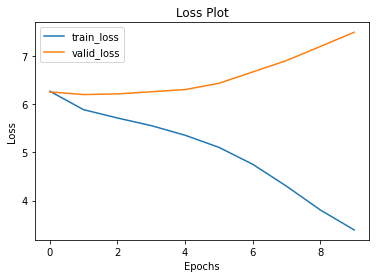

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_loss_plot, label='train_loss')
plt.plot(valid_loss_plot, label='valid_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()
plt.savefig('../images/loss.png')

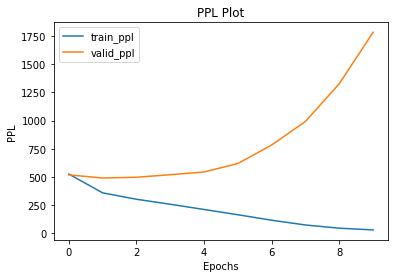

In [ ]:
plt.plot(train_ppl_plot, label='train_ppl')
plt.plot(valid_ppl_plot, label='valid_ppl')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('PPL')
plt.title('PPL Plot')
plt.show()
plt.savefig('../images/ppl.png')

### TensorBoard

https://pytorch.org/docs/stable/tensorboard.html

https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html

https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html

**Authorize TensorBoard.dev**

This step requires you to auth in your shell console, outside of Jupyter.  In your console, execute the following command.

`tensorboard dev list`

As part of this flow, you will be provided with an authorization code. This code is required to consent to the Terms of Service.

In [ ]:
!tensorboard dev list

**Upload to TensorBoard.dev**

Uploading the TensorBoard logs will give you a URL that can be shared with anyone.

Uploaded TensorBoards are public, so do not upload sensitive data.

The uploader will exit when the entire logdir has uploaded.  (This is what the `--one_shot` flag specifies.)

In [ ]:
!tensorboard dev upload --logdir ../logs \
  --name "Dialbot test" \
  --description "Training results from https://colab.research.google.com/drive/1XoBBD58GbTBEDC6gf7yULcHe5Q2tMY2G" \
  --one_shot

2021-04-25 19:01:18.340583: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/9qULsmkvS862QKK6SV5Q4g/

[2021-04-25T19:01:20] Started scanning logdir.
[2021-04-25T19:01:20] Total uploaded: 6 scalars, 0 tensors, 0 binary objects
[2021-04-25T19:01:20] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/9qULsmkvS862QKK6SV5Q4g/


Each individual upload has a unique experiment ID. This means that if you start a new upload with the same directory, you will get a new experiment ID.
You can list all the experiments you have uploaded using 
```
tensorboard dev list
```

In [ ]:
!tensorboard dev list

2021-04-25 18:14:17.338168: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
No experiments. Use `tensorboard dev upload` to get started.


## Test

Calculate test loss and perplexity. For the English model, we calculate loss and PPL for the training dataloader to compare it with the Euskara model. For the Euskara model, we compute loss and perplexity for the three sets, train, validation and test.

### English

In [34]:
#Load model
devide = 'cuda'
model_en.load_state_dict(torch.load('../model/en/model.pt', map_location=device))

<All keys matched successfully>

In [35]:
train_loss = valid(model_en, train_dataloader_en, criterion)
train_ppl = math.exp(train_loss)
print(f'\nTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f}')

100%|██████████| 1737/1737 [06:21<00:00,  4.55it/s]


Train Loss: 1.686 | Train PPL:   5.400


### Euskara

In [36]:
#Load model
devide = 'cuda'
model_eu.load_state_dict(torch.load('../model/eu/model.pt', map_location=device))

<All keys matched successfully>

In [38]:
train_loss = valid(model_eu, train_dataloader, criterion)
train_ppl = math.exp(train_loss)
print(f'\nTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f}')

100%|██████████| 6248/6248 [07:04<00:00, 14.70it/s]


Train Loss: 5.974 | Train PPL: 393.231


In [87]:
valid_loss = valid(model_eu, val_dataloader, criterion)
valid_ppl = math.exp(valid_loss)
print(f'\nValid Loss: {valid_loss:.3f} | Valid PPL: {valid_ppl:7.3f}')

100%|██████████| 781/781 [01:33<00:00,  8.31it/s]


Test Loss: 5.983 | Test PPL: 396.612


In [86]:
test_loss = valid(model_eu, test_dataloader, criterion)
test_ppl = math.exp(test_loss)
print(f'\nTest Loss: {test_loss:.3f} | Test PPL: {test_ppl:7.3f}')

100%|██████████| 781/781 [01:33<00:00,  8.37it/s]


Test Loss: 5.975 | Test PPL: 393.311


## Inference

In [39]:
import torch
import random
from argparse import ArgumentParser

MAX_LENGTH = 30

def decode(logits, tokenizer, decoding_strategy='multinomial', k=3, temp=0.4):
    tokenizer.decode(logits.topk(10)[1][0].numpy())
    if decoding_strategy=='top1':
        target = logits.max(1)[1]
    elif decoding_strategy=='topk':
        target = logits.topk(k)[1][0][random.randint(0, k-1)].unsqueeze(-1)
    else:
        target = torch.multinomial(logits.squeeze().div(temp).exp().cpu(), 1)
    return target

def evaluate(sentence, model, tokenizer, decoding_strategy='multinomial', k=3, temp=0.4):
    sentence = clean_line(sentence)
    sentence = tokenize_line(sentence)
    with torch.no_grad():
        target = torch.Tensor([tokenizer.token_to_id('<s>')]).long()
        output_sentence = []
        encoder_outputs, hidden = model.encoder(torch.Tensor(tokenizer.encode(sentence).ids).long().unsqueeze(-1))
        attentions = torch.zeros(MAX_LENGTH, 1, len(tokenizer.encode(sentence).ids)).to(device)
        for i in range(MAX_LENGTH):
            # first input to the decoder is the <sos> token
            output, hidden, attention = model.decoder(target, hidden, encoder_outputs)
            attentions[i] = attention
            target = decode(output, tokenizer, decoding_strategy, k, temp)
            if target.numpy() == tokenizer.token_to_id('</s>'):
                return sentence, tokenizer.decode(output_sentence), attentions[:i+1]
            else:
                output_sentence.append(target.numpy()[0])
    return sentence, tokenizer.decode(output_sentence), attentions

### English

In [40]:
#Load model
device = 'cpu'
model_en = model_en.to(device)
model_en.load_state_dict(torch.load('../model/en/model.pt', map_location=device))
tokenizer_en = get_tokenizer('../model/en/')

In [48]:
input_en = "Hello, how are you?"
sentence_en, output_en, attention_en = evaluate(input_en, model_en, tokenizer_en)
print(output_en)

i 'm great  .  !  i have a boyfriend  ?


### Euskara

In [43]:
#Load model
device = 'cpu'
model_eu = model_eu.to(device)
model_eu.load_state_dict(torch.load('../model/eu/model.pt', map_location=device))
tokenizer_eu = get_tokenizer('../model/eu/')

In [59]:
input_eu = "Kaixo, zer moduz zaude?"
sentence_eu, output_eu, attention_eu = evaluate(input_eu, model_eu, tokenizer_eu)
print(output_eu)

zer moduz ?


## Attention

Next, we'll make a function that displays the model's attention over the source sentence for each target token generated. Then we'll use our `evaluate` function to get our predicted sentence and attention.  We show this graphically by having the source sentence on the x-axis and the predicted sentence on the y-axis. The lighter the square at the intersection between two words, the more attention the model gave to that source word when translating that target word.

In [45]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
def display_attention(sentence, prediction, attention):
    sentence = sentence.split(' ')
    prediction = prediction.split(' ')
    prediction.append('</s>')
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + ['<s>'] + [t.lower() for t in sentence] + ['<\s>']
    y_ticks = [''] + prediction
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

### English

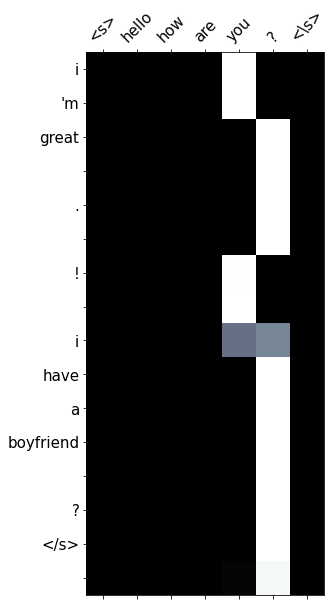

In [60]:
display_attention(sentence_en, output_en, attention_en)

### Euskara

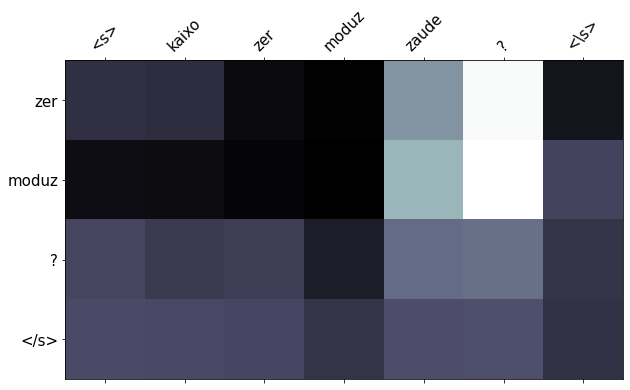

In [61]:
display_attention(sentence_eu, output_eu, attention_eu)

## Dialog

In [64]:
def dialog(model, tokenizer, decoding_strategy='multinomial', k=3, temp=0.4):
    #Print welcome message
    print('-------------------------------')
    print('Welcome to Dialbot system')
    print("Write 'Bye' or 'Agur' to end the system.")
    print('-------------------------------')

    # Main system loop
    user = input('-')
    model.eval()

    while user != 'Bye' and user != 'Agur':
        sentence, output, attention = evaluate(user, model, tokenizer, decoding_strategy)
        print('+' + output.capitalize())
        user = input('-')
        
    sentence, output, attention = evaluate(user, model, tokenizer, decoding_strategy)
    print('+' + output.capitalize())

### English

In [65]:
dialog(model_en, tokenizer_en)

-------------------------------
Welcome to Dialbot system
Write 'Bye' or 'Agur' to end the system.
-------------------------------
-Hello
+Hi there  !  i a high school  .  you  ?
-Bye
+Oh yeah  ?  yeah  ?


### Euskara

In [66]:
dialog(model_eu, tokenizer_eu)

-------------------------------
Welcome to Dialbot system
Write 'Bye' or 'Agur' to end the system.
-------------------------------
-Kaixo
+Zer moduz zaude ?
-Ondo
+Eta .
-Agur
+Agur .


## BLEU

Previously we have only cared about the loss/perplexity of the model. However there metrics that are specifically designed for measuring the quality of a translation - the most popular is *BLEU*. Without going into too much detail, BLEU looks at the overlap in the predicted and actual target sequences in terms of their n-grams. It will give us a number between 0 and 1 for each sequence, where 1 means there is perfect overlap, i.e. a perfect translation, although is usually shown between 0 and 100. BLEU was designed for multiple candidate translations per source sequence, however in this dataset we only have one candidate per source.

We define a `calculate_bleu` function which calculates the BLEU score over a provided TorchText dataset. This function creates a corpus of the actual and predicted translation for each source sentence and then calculates the BLEU score.

In [67]:
from torchtext.data.metrics import bleu_score
def calculate_bleu(dataloader, model, tokenizer, decoding_strategy='multinomial', k=3, temp=0.4):
    targets = []
    predictions = []
    for iteration, (src, trg) in tqdm(enumerate(dataloader), total=len(dataloader), position=0, leave=True):
        src, trg = src.to(device), trg.to(device)

        # swap axes and remove <s>
        src_swap = src.swapaxes(0, 1)[:, 1:]
        trg_swap = trg.swapaxes(0, 1)[:, 1:]

        src_sentences = tokenizer.decode_batch(src_swap.numpy())
        trg_sentences = tokenizer.decode_batch(trg_swap.numpy())

        for i in range(len(src_sentences)):
            # remove padding and </s>
            target = trg_sentences[i].split("</s>")[0]
            target_list = target.split(' ')
            targets.append([target_list])

            sentence = src_sentences[i].split("</s>")[0]
            sentence, prediction, attention = evaluate(sentence, model, tokenizer, decoding_strategy, k, temp)
            prediction_list = prediction.split(' ')
            predictions.append(prediction_list)
        
        if iteration > 5:
            break

    return bleu_score(predictions, targets)

### English

In [68]:
#Load model
devide = 'cpu'
model_en = model_en.to(device)
model_en.load_state_dict(torch.load('../model/en/model.pt', map_location=device))
tokenizer_en = get_tokenizer('../model/en/')

In [71]:
bleu = calculate_bleu(train_dataloader_en, model_en, tokenizer_en)
print()
print(f'Train BLEU score = {bleu*100:.2f}')

  0%|          | 6/1737 [02:01<9:44:29, 20.26s/it]


Train BLEU score = 28.86


### Euskara

In [70]:
#Load model
devide = 'cpu'
model_eu = model_eu.to(device)
model_eu.load_state_dict(torch.load('../model/eu/model.pt', map_location=device))
tokenizer_eu = get_tokenizer('../model/eu/')

In [72]:
bleu = calculate_bleu(train_dataloader, model_eu, tokenizer_eu)
print()
print(f'Train BLEU score = {bleu*100:.2f}')

  0%|          | 6/6248 [00:12<3:38:04,  2.10s/it]


Train BLEU score = 0.00


In [73]:
device = 'cpu'
bleu = calculate_bleu(test_dataloader, model_eu, tokenizer_eu)
print()
print(f'Test BLEU score = {bleu*100:.2f}')

  1%|          | 6/781 [00:12<27:15,  2.11s/it]


Test BLEU score = 0.00
